# Filippo Conforto - RLab 06

### Functions and libraries

In [4]:
library(tidyverse, quiet = TRUE)
library(graphics)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [5]:
find_mean = function (pos, lower, upper) {
    integrate(function(x) pos(x)*x, lower, upper)[[1]]
}

In [6]:
find_variance = function (pos, lower, upper) {
    integrate(function(x) pos(x)*x^2, lower, upper)[[1]]-find_mean(pos, lower, upper)^2
}

In [7]:
s_dec <- function(x, k) trimws(format(round(x, k), nsmall=k))

## Exercise 1

### A

Analitically, the posterior is a gamma function, since it is obtained as a product of poisson likelihoods. Using an improper uniform prior the final posterior is obtained as
$\Gamma(\lambda,\alpha=13,\beta = 5)\mathbb{1}_{[0,+\infty]}$, since the sum of particle observed is 13, and the total number of observations is 5. Is now possible to study the properties of this function.

In [1]:
unif_post= function(x){
    dgamma(x,13,5)
}

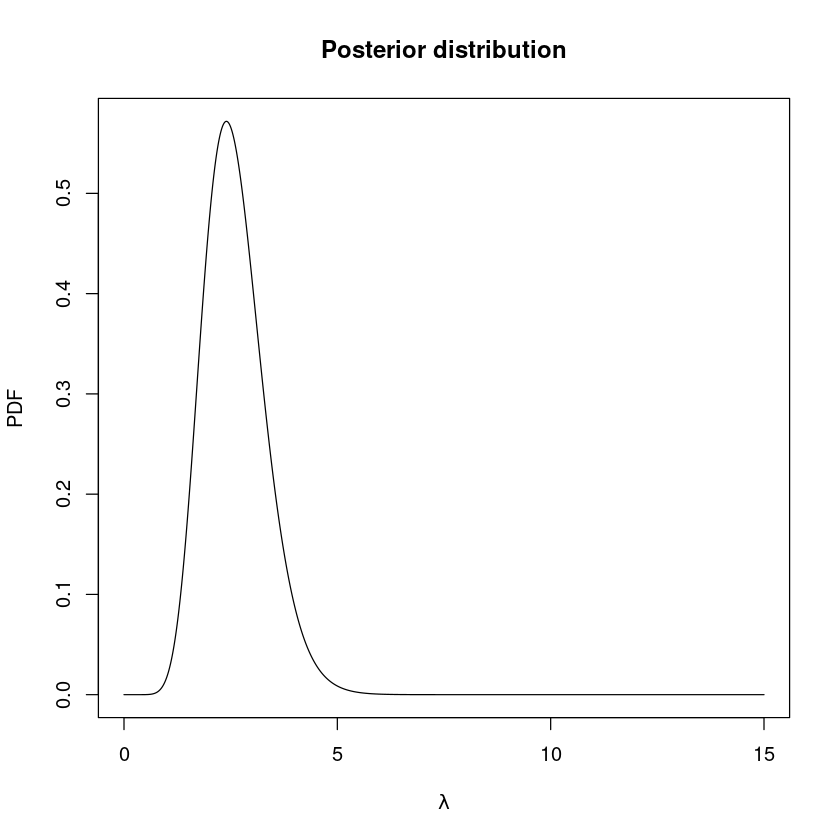

In [2]:
plot(seq(0,15,0.01),unif_post(seq(0,15,0.01)), t = "l", main = "Posterior distribution", xlab = expression(lambda), ylab = "PDF")

In [18]:
message("The numerical value of the mean is ", s_dec(find_mean(unif_post, 0, 15),1)
        , ", while analytically is ",13/5)
message("The numerical value of the median is ", s_dec(qgamma(0.5,13,5),3)
        ,", while analytically it can't be computed")
message("The numerical value of the variance is ", s_dec(find_variance(unif_post,0,15),2)
        ,", while analytically it is ",13/25)

The numerical value of the mean is 2.6, while analytically is 2.6

The numerical value of the median is 2.534, while analytically it can't be computed

The numerical value of the variance is 0.52, while analytically it is 0.52



### B

Using a Jeffrey prior($\frac{1}{\sqrt{\lambda}}$), the resulting posterior is $\frac{\Gamma(\lambda,\alpha=13,\beta = 5)}{\sqrt{\lambda}}=\Gamma(\lambda,\alpha=12.5,\beta = 5)$.

In [10]:
jeff_post = function(x){
    dgamma(x,12.5,5)
}

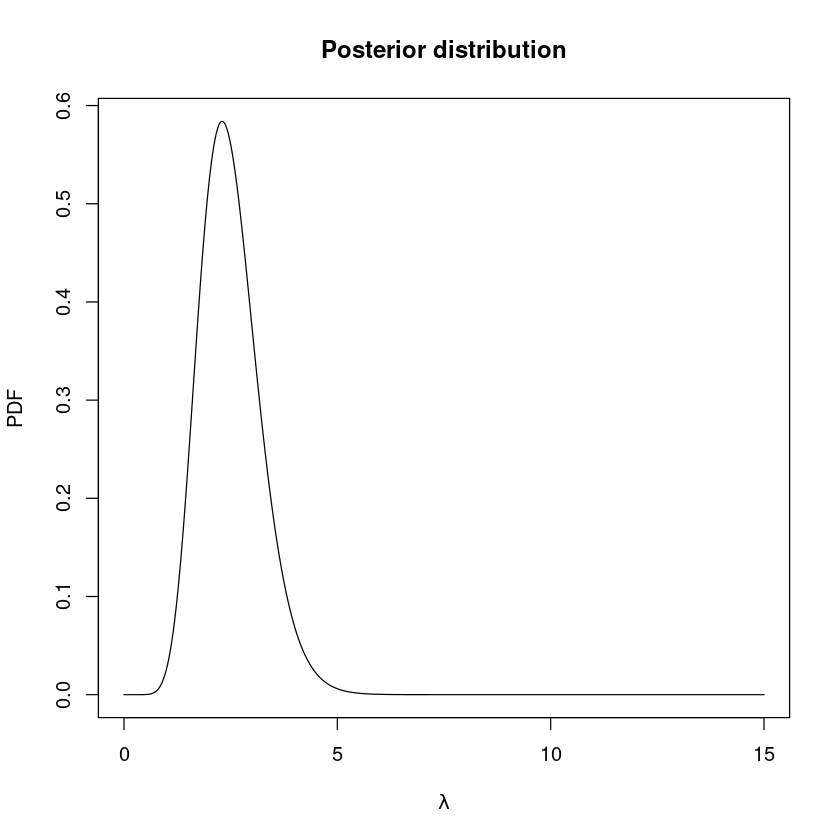

In [11]:
plot(seq(0,15,0.01),jeff_post(seq(0,15,0.01)), t = "l", main = "Posterior distribution", xlab = expression(lambda), ylab = "PDF")

In [17]:
message("The numerical value of the mean is ", s_dec(find_mean(jeff_post, 0, 15),1)
        , ", while analytically is ",12.5/5)
message("The numerical value of the median is ", s_dec(qgamma(0.5,12.5,5),3)
        ,", while analytically it can't be computed")
message("The numerical value of the variance is ", s_dec(find_variance(jeff_post,0,15),1)
        ,", while analytically it is ",12.5/25)


The numerical value of the mean is 2.5, while analytically is 2.5

The numerical value of the median is 2.434, while analytically it can't be computed

The numerical value of the variance is 0.5, while analytically it is 0.5



### C

In [16]:
message("The 95% credibility interval for the first posterior is [",s_dec(qgamma(0.025,13,5),2),",",s_dec(qgamma(0.975,13,5),2),"]")
message("The same credibility interval given by a normal distribution with the same mean and average is [",s_dec(qnorm(0.025,mean = find_mean(unif_post, 0, 15), sd = sqrt(find_variance(unif_post, 0, 15))),2),",",s_dec(qnorm(0.975,mean = find_mean(unif_post, 0, 15), sd = sqrt(find_variance(unif_post, 0, 15))),2),"]")
message("The 95% credibility interval for the second posterior is [",s_dec(qgamma(0.025,12.5,5),2),",",s_dec(qgamma(0.975,12.5,5),2),"]")
message("The same credibility interval given by a normal distribution with the same mean and average is [",s_dec(qnorm(0.025,mean = find_mean(jeff_post, 0, 15), sd = sqrt(find_variance(jeff_post, 0, 15))),2),",",s_dec(qnorm(0.975,mean = find_mean(jeff_post, 0, 15), sd = sqrt(find_variance(jeff_post, 0, 15))),2),"]")


The 95% credibility interval for the first posterior is [1.38,4.19]

The same credibility interval given by a normal distribution with the same mean and average is [1.19,4.01]

The 95% credibility interval for the second posterior is [1.31,4.06]

The same credibility interval given by a normal distribution with the same mean and average is [1.11,3.89]



## Exercise 2

The lighthouse problem concernes the inference over the position in the sea ($\alpha$ defined as the position along the shore, and $\beta$ defined as the distance at the sea), starting from the detection of emitted pulses on the coast.
The pulse detections are obtained via simulation, with a sampler defined using angles drawn from a uniform distribution over $\left[ -\frac{\pi}{2},\frac{\pi}{2}\right]$, from which the corresponding observation point is obtained as $x=\beta\tan{\theta}+\alpha$. 

In [8]:
## Sampler
samp = function(n, alpha =1, beta =1){
    return(tan(runif(n,min = -pi/2, max = pi/2))*beta + alpha)
}

The likelihood is obtained from the previous expression for x as $P(x| \alpha, \beta)=\frac{1}{\pi}\frac{\beta}{\beta^2+(x-\alpha)^2}$

In [9]:
likelihood = function(x,alpha=1,beta=1){
    beta/(pi*(beta^2+(x-alpha)^2))
}

The posterior distribution over $\alpha$ and $\beta$ is updated using a dense grid of points.

In [10]:
update_grid = function (grid,x,a,b){
    for(j in 1: length (a)) {
        for(k in 1: length (b)) {
            grid[j,k] <- likelihood(x,a[j],b[k])*grid[j,k]
            }
        }
    #Normalization by sum over the points multiplied by the single square area
    return(grid/(sum(grid*0.04^2)))
    }

The grid is used as an uniform prior and it is initialized with $10^4$ points of value $1/10^4$, such that the probability is normalized.

In [11]:
alim <- c(0, 4.0)
blim <- c(1, 6)
Nsamp <- 100
uniGrid <- seq(from=1/(2* Nsamp),
to=1-1/(2*Nsamp), by=1/ Nsamp)
delta_a <- diff(alim )/ Nsamp
delta_b <- diff(blim )/ Nsamp
a <- alim[1] + diff(alim )* uniGrid
b <- blim[1] + diff(blim )* uniGrid
grid = matrix ( data = rep(1/10^4,10^4), nrow = length(a), ncol = length(b))
grid2 = matrix ( data = rep(1/10^4,10^4), nrow = length(a), ncol = length(b))
grid3 = matrix ( data = rep(1/10^4,10^4), nrow = length(a), ncol = length(b))
grid4 = matrix ( data = rep(1/10^4,10^4), nrow = length(a), ncol = length(b))

Now is possible to do bayesian inference, with different observation batch sizes.

In [12]:
sample = samp(1000, alpha =2, beta = 3)

In [13]:
for(i in sample[1:150]){
    grid = update_grid(grid, i,a,b)
}
for(i in sample[1:400]){
    grid2 = update_grid(grid2, i,a,b)
}
for(i in sample[1:600]){
    grid3 = update_grid(grid3, i,a,b)
}
for(i in sample){
    grid4 = update_grid(grid4, i,a,b)
}
l_grid = list(grid,grid2,grid3,grid4)

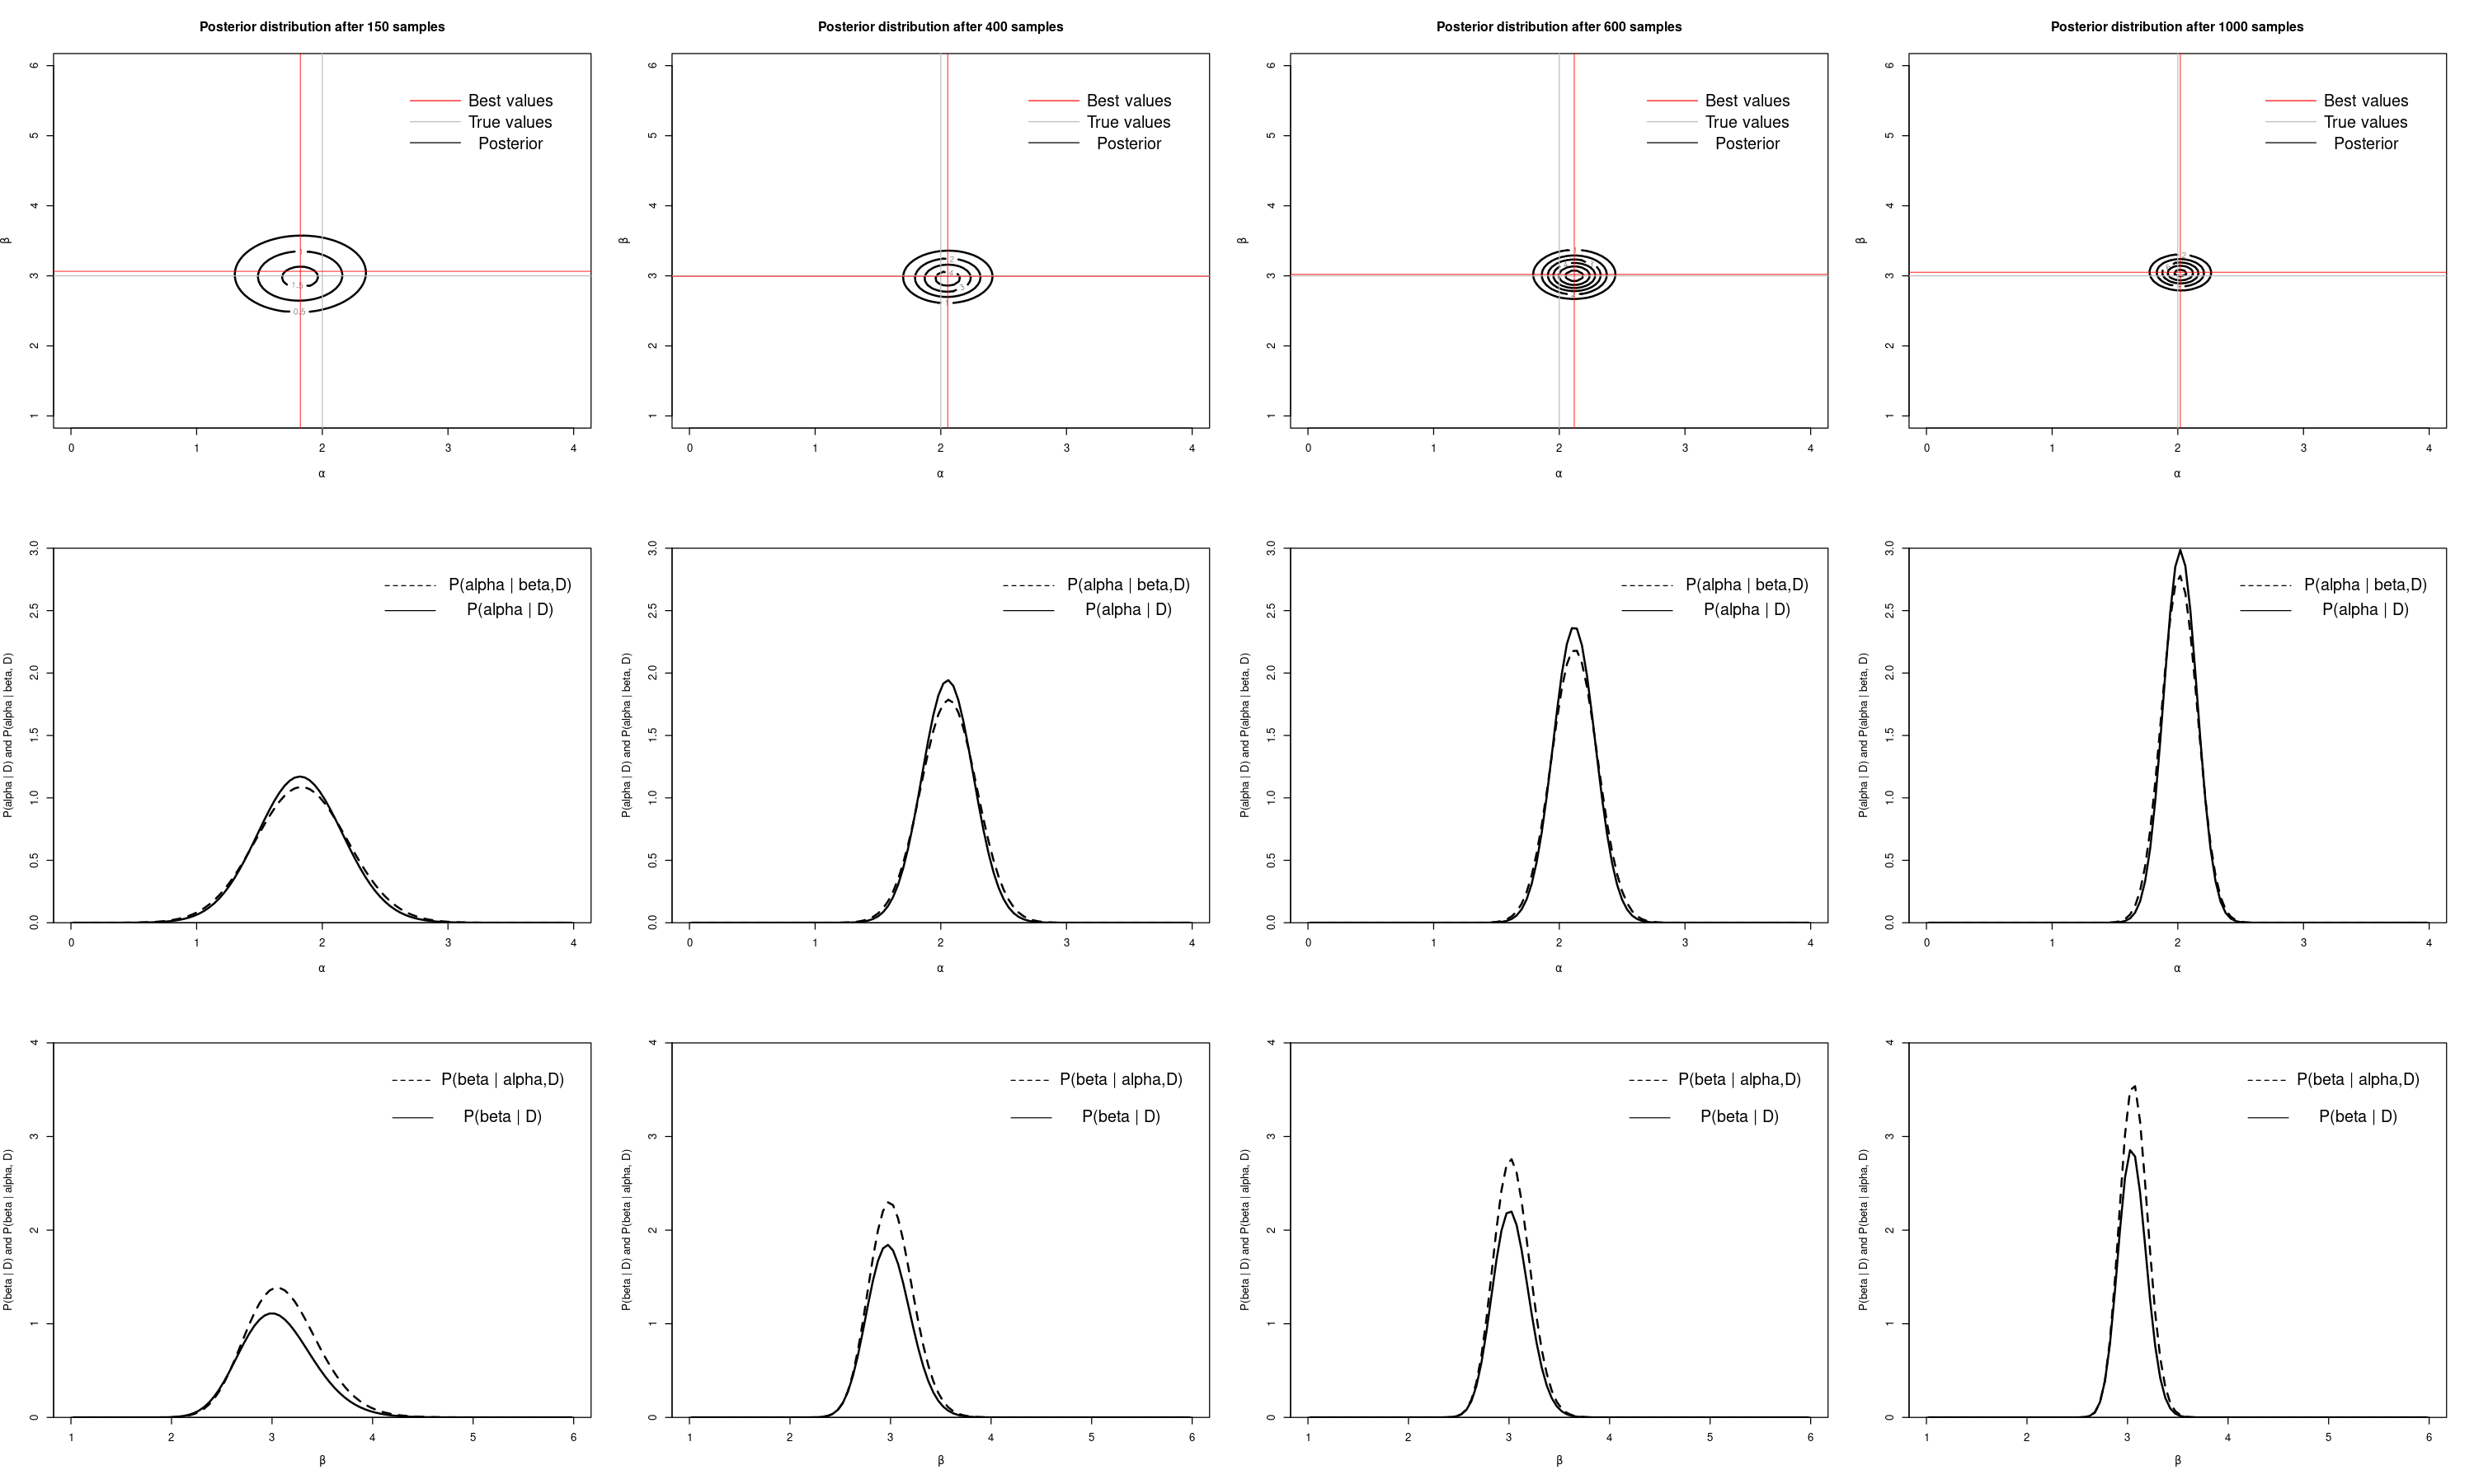

In [19]:
options(repr.plot.width = 25,repr.plot.height =15)
layout(matrix(1:12,nrow=3,ncol=4))
for (i in 1:4){
    contour (a, b, l_grid[[i]],
    nlevels = 5,
    labcex = 0.5,
    lwd = 2,
    xlab=expression(alpha),
    ylab=expression(beta),
    main = paste("Posterior distribution after",c(150,400,600,1000)[[i]],"samples"))
    abline (v=2,h=3,col="grey")
    segments(2.7,5.5,3.1,5.5,col="red")
    text(3.5,5.5,"Best values", cex =1.5)
    segments(2.7,5.2,3.1,5.2,col="grey")
    text(3.5,5.2,"True values", cex =1.5)
    segments(2.7,4.9,3.1,4.9,col="black")
    text(3.5,4.9,"Posterior", cex =1.5)
    #legend(2.7, 6, legend=c("Best", "True value", "Posterior distribution"),
    #   col=c("red", "grey","black"), lty=c(1,1,1), cex=0.5)
    p_a_D <- apply(l_grid[[i]], 1, sum)
    p_a_D <- p_a_D/( delta_a*sum(p_a_D))
    p_a_bD <-l_grid[[i]][,2/delta_a]
    p_a_bD <- p_a_bD/( delta_a*sum(p_a_bD))
    p_b_D <- apply(l_grid[[i]], 2, sum)
    p_b_D <- p_b_D/( delta_b*sum(p_b_D))
    p_b_aD <-l_grid[[i]][3/delta_b,]
    p_b_aD <- p_b_aD/( delta_a*sum(p_b_aD))
    mean_a <- delta_a * sum(a * p_a_D)
    mean_b <- delta_b * sum(b * p_b_D)
    abline (v=mean_a,h=mean_b,col=rgb(1,0,0, alpha = 0.7))
    plot(a, p_a_D, xlab=expression(alpha), yaxs="i",
    ylim=c(0,3), ylab=paste(expression(P(alpha | D)),"and",expression( P(alpha | beta,D))),
    type="l", lwd=2)
    lines (a, p_a_bD , lwd=2, lty=2)
    segments(2.5,2.5,2.9,2.5,col="black")
    text(3.5,2.5,"P(alpha | D)", cex =1.5)
    segments(2.5,2.7,2.9,2.7,col="black", lty=2)
    text(3.5,2.7,"P(alpha | beta,D)", cex =1.5)
    plot(b, p_b_D, xlab=expression(beta), yaxs="i",
    ylim=c(0,4), ylab=paste(expression(P(beta | D)),"and",expression( P(beta | alpha,D))),
    type="l", lwd=2)
    lines (b, p_b_aD , lwd=2, lty=2)
    segments(4.2,3.2,4.6,3.2,col="black")
    text(5.3,3.2,"P(beta | D)", cex =1.5)
    segments(4.2,3.6,4.6,3.6,col="black", lty=2)
    text(5.3,3.6,"P(beta | alpha,D)", cex =1.5)
}


As is possible to see, with more samples is possible to get more accurate results.

## Exercise 3

In this exercise are exploited some results coming from changes in both the resolution and the A/B ratio for the Signal over Background example.

In [21]:
# - Generative model)
signal = function (x, a, b, x0, w, t) {
t * (a*exp (-(x-x0)^2/(2*w^2)) + b)
}

results = function(z, delta_a, delta_b, ddat, xdat, A.true, B.true,a, b, x0, w, Delta.t){
    # Compute normalized marginalized posteriors , P(a|D) and P(b|D)
    # by summing over other parameter . Normalize by gridding .
    p_a_D <- apply(exp(z), 1, sum)
    p_a_D <- p_a_D/( delta_a*sum(p_a_D))
    p_b_D <- apply(exp(z), 2, sum)
    p_b_D <- p_b_D/( delta_b*sum(p_b_D))
    # Compute normalized conditional posteriors , P(a|b,D) and P(b|a,D)
    # using true values of conditioned parameters . Vectorize (func , par)
    # makes a vectorized function out of func in the parameter par.
    p_a_bD <- exp( Vectorize (log.post , "a")(ddat , xdat , a, B.true ,
    x0, w, Delta.t))
    p_a_bD <- p_a_bD/( delta_a*sum(p_a_bD))
    p_b_aD <- exp( Vectorize (log.post , "b")( ddat , xdat , A.true , b,
    x0, w, Delta.t))
    p_b_aD <- p_b_aD/( delta_b*sum(p_b_aD))
    

    # Compute mean , standard deviation , covariance , correlation , of A and B
    mean_a <- delta_a * sum(a * p_a_D)
    mean_b <- delta_b * sum(b * p_b_D)
    sd_a <- sqrt( delta_a * sum ((a-mean_a)^2 * p_a_D) )
    sd_b<- sqrt( delta_b * sum ((b-mean_b)^2 * p_b_D) )
    cov_ab <- 0
    for(j in 1: length (a)) {
    for(k in 1: length (b)) {
    cov_ab <- cov_ab + (a[j]-mean_a)*(b[k]-mean_b)* exp(z[j,k])
        }
    }
    cov_ab <- cov_ab / sum(exp(z))
    rho_ab <- cov_ab / (sd_a * sd_b)
    return(list(p_a_D,p_b_D, p_a_bD, p_b_aD,mean_a, mean_b))
}
sig_plot = function (x0,w,A.true,B.true,Delta.t,seed, ddat, xdat,main){
    xplot <- seq(from=min(xdat), to=max(xdat), by=0.05)
    splot <- signal (xplot , A.true , B.true , x0, w, Delta.t)
    xdat.off <- xdat - 0.25*w
    plot(xdat.off , ddat , type="s",col="firebrick 3",
    lwd=2,xlim=range(xplot), ylim= range (c(splot , ddat )),xlab="x", ylab=" Signal + Background counts ", main = main)
    lines(xplot, splot, lw =3.5)
}

grid_def = function(alim,blim){
    Nsamp <- 100
    uniGrid <- seq(from=1/(2* Nsamp ),
    to=1-1/(2*Nsamp), by=1/ Nsamp )
    delta_a <- diff(alim )/ Nsamp
    delta_b <- diff(blim )/ Nsamp
    a <- alim[1] + diff(alim )* uniGrid
    b <- blim[1] + diff(blim )* uniGrid
    return(list(a,b,delta_a,delta_b))
    }

log.post <- function (d, x, a, b, x0, w, t, A.true =2, B.true = 1) {
    if(a<0 || b <0) { return (-Inf )} # the effect of the prior
    sum( dpois(d, lambda = signal (x, a, b, x0, w, t), log=TRUE ))
}

c_plot = function(ddat , xdat,x0,w, Delta.t ,A.true=2,B.true=1, main,alim,blim, delta_a,delta_b){
    options(repr.plot.width = 16, repr.plot.height =16)
    ab = grid_def(alim,blim)
    a = ab[[1]]
    b = ab[[2]]
    delta_a = ab[[3]]
    delta_b = ab[[4]]
    z <- matrix (data=NA , nrow= length (a), ncol= length (b))
    for(j in 1: length (a)) {
    for(k in 1: length (b)) {
            z[j,k] <- log.post(ddat , xdat , a[j], b[k], x0, w, Delta.t)
        }
    }
    z <- z - max(z) # set maximum to zero
    results = results(z, delta_a, delta_b, ddat, xdat, A.true, B.true, a,b, x0, w, Delta.t)
    mean_a = results[[5]]
    mean_b = results[[6]]
    p_a_D = results[[1]]
    p_b_D = results[[2]]
    p_a_bD = results[[3]]
    p_b_aD = results[[4]]
    contour (a, b, exp(z),
    nlevels = 5,
    labcex = 0.5,
    lwd = 2,
    xlab="Amplitude , A",
    ylab="Background , B",
    main = main   )
    segments((A.true -2) +2.5,blim[[2]]-min(blim[[2]]/10,0.5),(A.true -2) +2.8,blim[[2]]-min(blim[[2]]/10,0.5),col="red")
    text((A.true -2) +3.5,blim[[2]]-min(blim[[2]]/10,0.5),"Best values", cex =1.5)
    segments((A.true -2) +2.5,blim[[2]]-2*min(blim[[2]]/10,0.5),(A.true -2) +2.8,blim[[2]]-2*min(blim[[2]]/10,0.5),col="grey")
    text((A.true -2) +3.5,blim[[2]]-2*min(blim[[2]]/10,0.5),"True values", cex =1.5)
    segments((A.true -2) +2.5,blim[[2]]-3*min(blim[[2]]/10,0.5),(A.true -2) +2.8,blim[[2]]-3*min(blim[[2]]/10,0.5),col="black")
    text((A.true -2) +3.5,blim[[2]]-3*min(blim[[2]]/10,0.5),"Posterior", cex =1.5)
    abline (v=A.true,h=B.true,col="grey")
    abline (v=mean_a,h=mean_b,col=rgb(1,0,0, alpha = 0.7))
    plot(b, p_b_D, xlab="Background , B", yaxs="i",
    ylim=1.05*c(0,5.5), ylab="P(B | D) and P(B | A,D)",
    type="l", lwd=2, main ="PDF for the Amplitude parameter")
    lines (b, p_b_aD , lwd=2, lty=2)
    abline (v=B.true , col="grey")
    segments((B.true -1.5) +2,3.8,(B.true -1.5) +2.5,3.8,col="black")
    text((B.true -1.5) +3,3.8,"P(B | D)", cex =1.5)
    segments((B.true -1.5) +2,4.4,(B.true -1.5) +2.5,4.4,col="black", lty=2)
    text((B.true -1.5) +3,4.4,"P(B | A,D)", cex =1.5)
    plot(a, p_a_D, xlab="Amplitude , A", yaxs="i",
    ylim=1.05*c(0,2), ylab="P(A | D) and P(A | B,D)",
    type="l", lwd=2, main ="PDF for the Background parameter")
    lines (a, p_a_bD , lwd=2, lty=2)
    abline (v=A.true , col="grey")
    segments((A.true -2) +2.5,1.5,(A.true -2) +2.9,1.5,col="black")
    text((A.true -2) +3.5,1.5,"P(A | D)", cex =1.5)
    segments((A.true -2) +2.5,1.7,(A.true -2) +2.9,1.7,col="black", lty=2)
    text((A.true -2) +3.5,1.7,"P(A | B,D)", cex =1.5)
    return(z)
    
}


model = function(x0,w,A.true,B.true,Delta.t,seed){
    set.seed(seed)
    xdat <- seq(from=-8, to=8, by=0.5)
    s.true <- signal (xdat , A.true , B.true , x0, w, Delta.t)
    ddat <- rpois( length (s.true), s.true)
    return (list(ddat,xdat,s.true))
}

Using these functions is possible to simulate the signal data obtained from this phenomena, and eventually change the presets.
The simulated data obtained with these different parameters can show some interesting relations.

### A
This section contains the results obtained using data produced with different resolutions (0.1,0.25,1,2,3) and the same sampling range ([-8,8]).

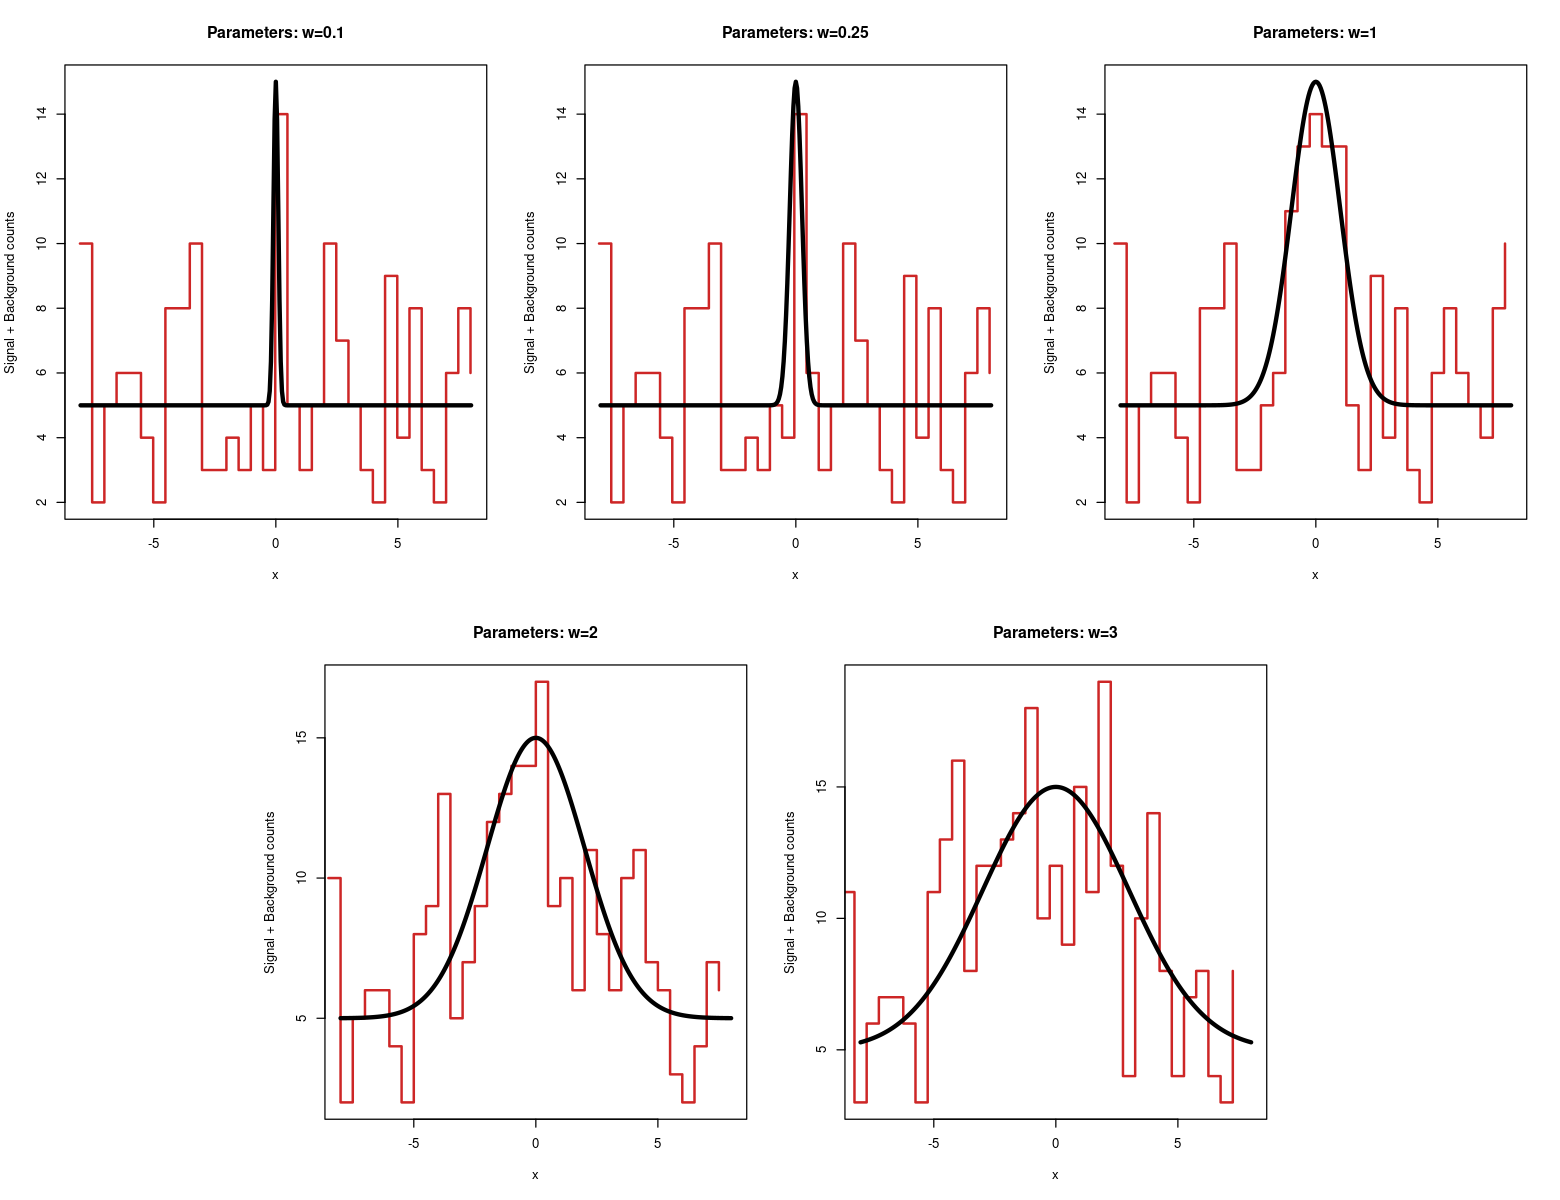

In [22]:
v1 = model(0,0.1,2,1,5,205)
v2 = model(0,0.25,2,1,5,205)
v3 = model(0,1,2,1,5,205)
v4 = model(0,2,2,1,5,205)
v5 = model(0,3,2,1,5,205)
v = list(v1,v2,v3,v4,v5)

options(repr.plot.width = 13, repr.plot.height =10)

layout(matrix(c(1,1,1,1,2,2,2,2,3,3,3,3,0,0,4,4,4,4,5,5,5,5,0,0), nrow=2, ncol = 12, byrow = TRUE))
w_i = c(0.1,0.25,1,2,3)
for (i in 1:5){
    sig_plot(0,w_i[[i]],2,1,5,205,v[[i]][[1]],v[[i]][[2]],main = paste0("Parameters: w=",w_i[[i]]))
}

By changing the resolution is possible to see that with lower values the resulting  signal is much more noisy with respect to the standard case. This will obviously reduce the precision the inference process and make much more difficult to find the correct parameters for the model.

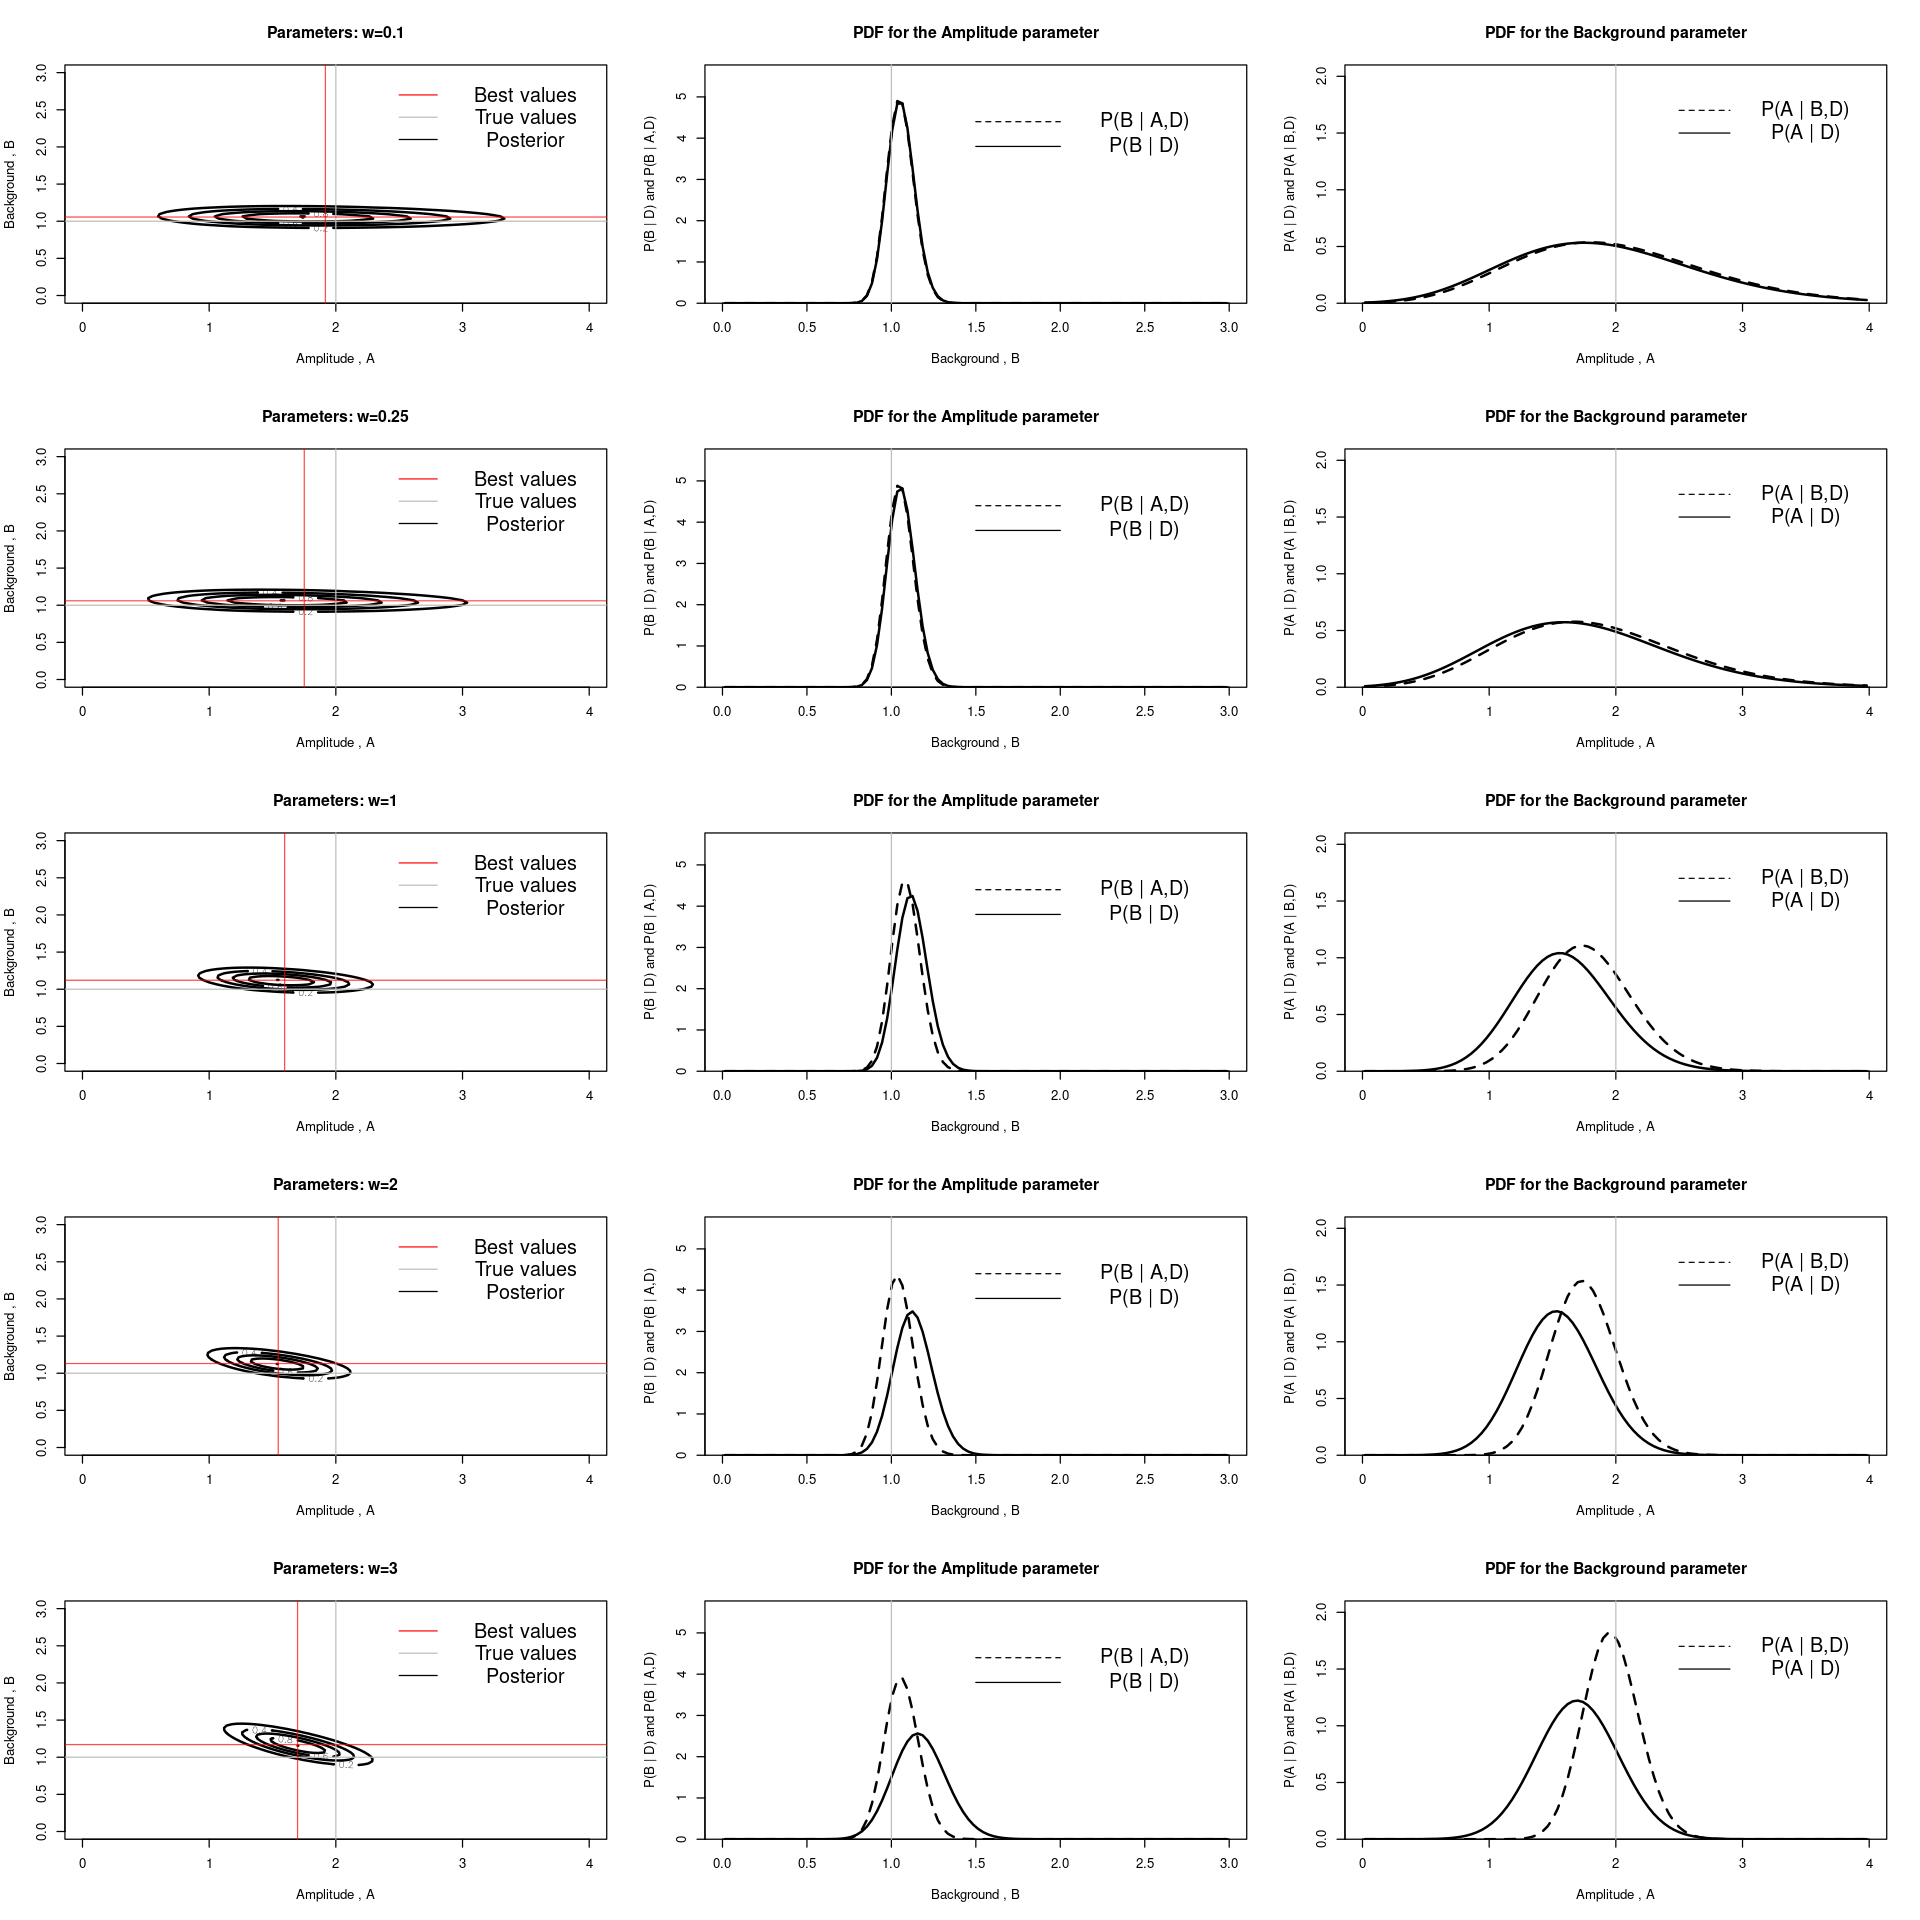

In [23]:
layout(matrix(1:15, nrow=5, ncol = 3, byrow = TRUE))
options(repr.plot.width = 16, repr.plot.height =16)
for (i in 1:5){
    c_plot(v[[i]][[1]],v[[i]][[2]],0,w_i[[i]],5, main = paste0("Parameters: w=",w_i[[i]]),alim = c(0,4), blim =c(0,3))
}


As predictable the resulting distribution is much more narrower with cleaner data, while for the first two cases the result in very unprecise and gives a larger distribution. Is interesting also to notice that with a larger resolution the result is less accurate for the parameter B, probably because is more difficult to correctly estimate the background, with such a large signal.

### B

By changing the value of true A and B, is possible to change the shape of the produced signal. With higher values of A, the signal becomes stronger with a taller peak, while a larger B produces a taller baseline for the signal.

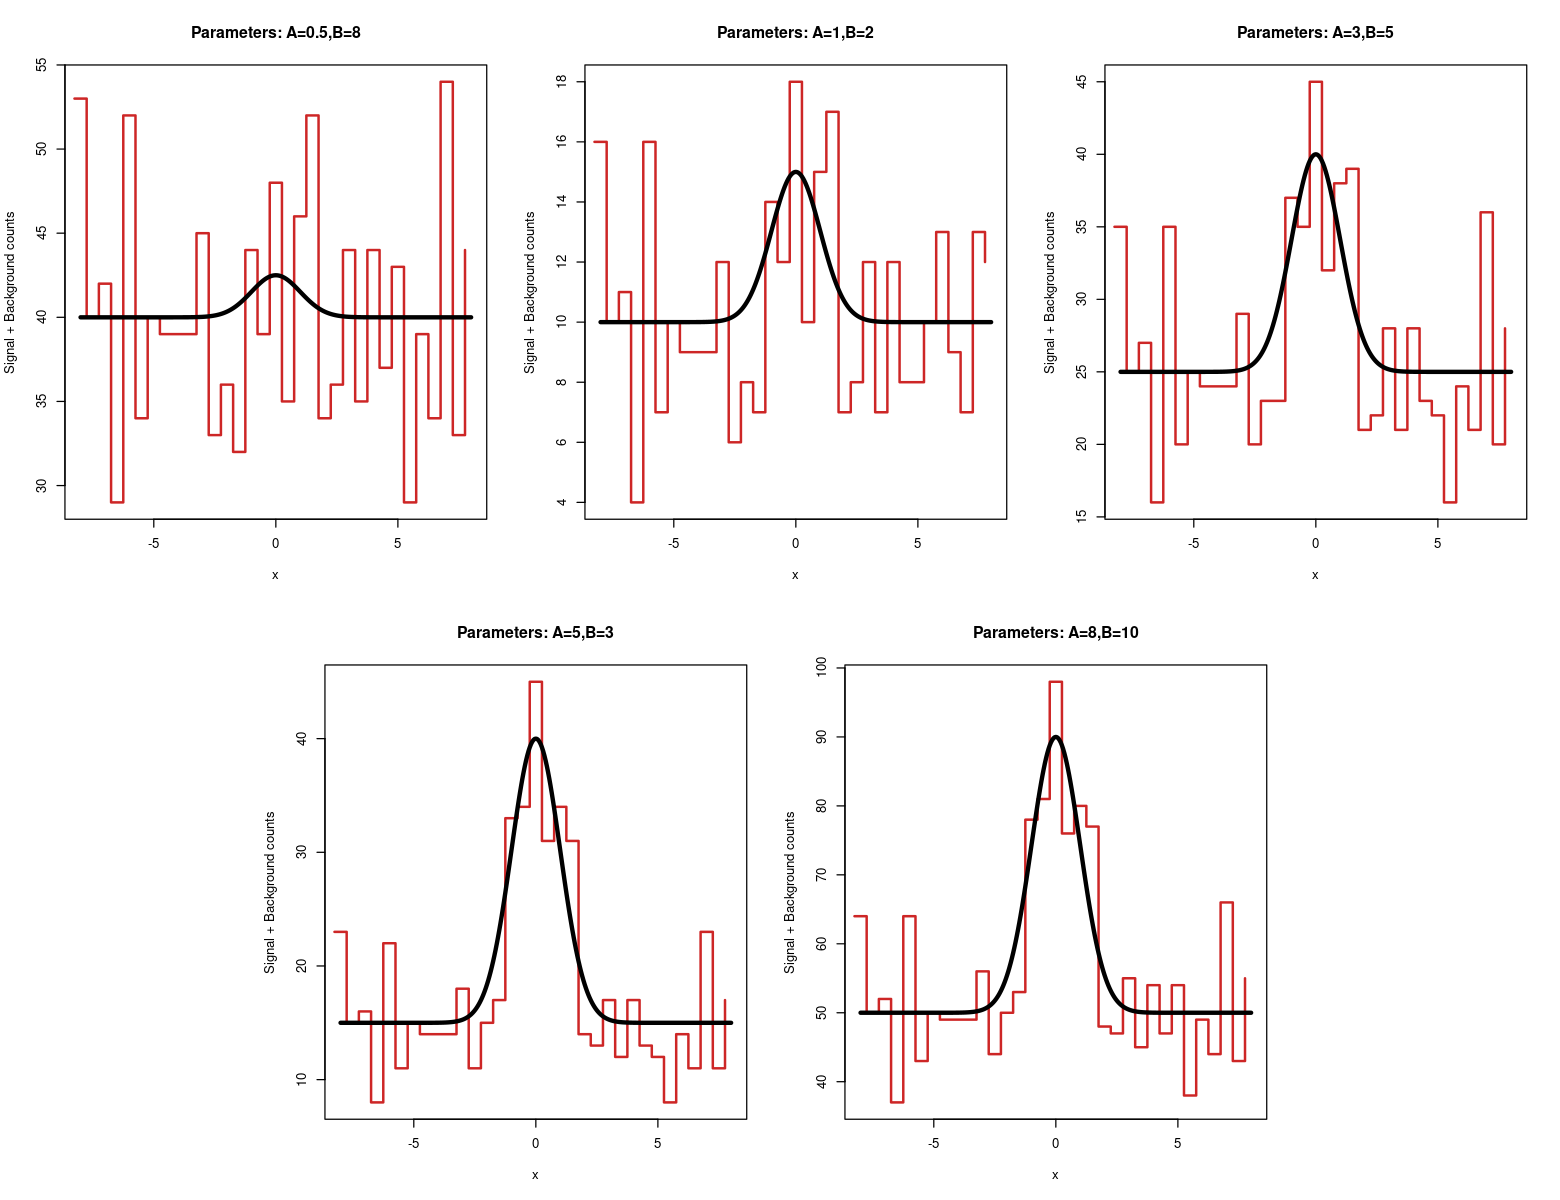

In [28]:
v1 = model(0,1,0.5,8,5,205)
v2 = model(0,1,1,2,5,205)
v3 = model(0,1,3,5,5,205)
v4 = model(0,1,5,3,5,205)
v5 = model(0,1,8,10,5,205)
v = list(v1,v2,v3,v4,v5)

options(repr.plot.width = 13, repr.plot.height =10)

layout(matrix(c(1,1,1,1,2,2,2,2,3,3,3,3,0,0,4,4,4,4,5,5,5,5,0,0), nrow=2, ncol = 12, byrow = TRUE))
a_i = c(0.5,1,3,5,8)
b_i = c(8,2,5,3,10)
for (i in 1:5){
    sig_plot(0,1,a_i[[i]],b_i[[i]],5,205,v[[i]][[1]],v[[i]][[2]],main = paste0("Parameters: A=",a_i[[i]],",B=",b_i[[i]]))
}

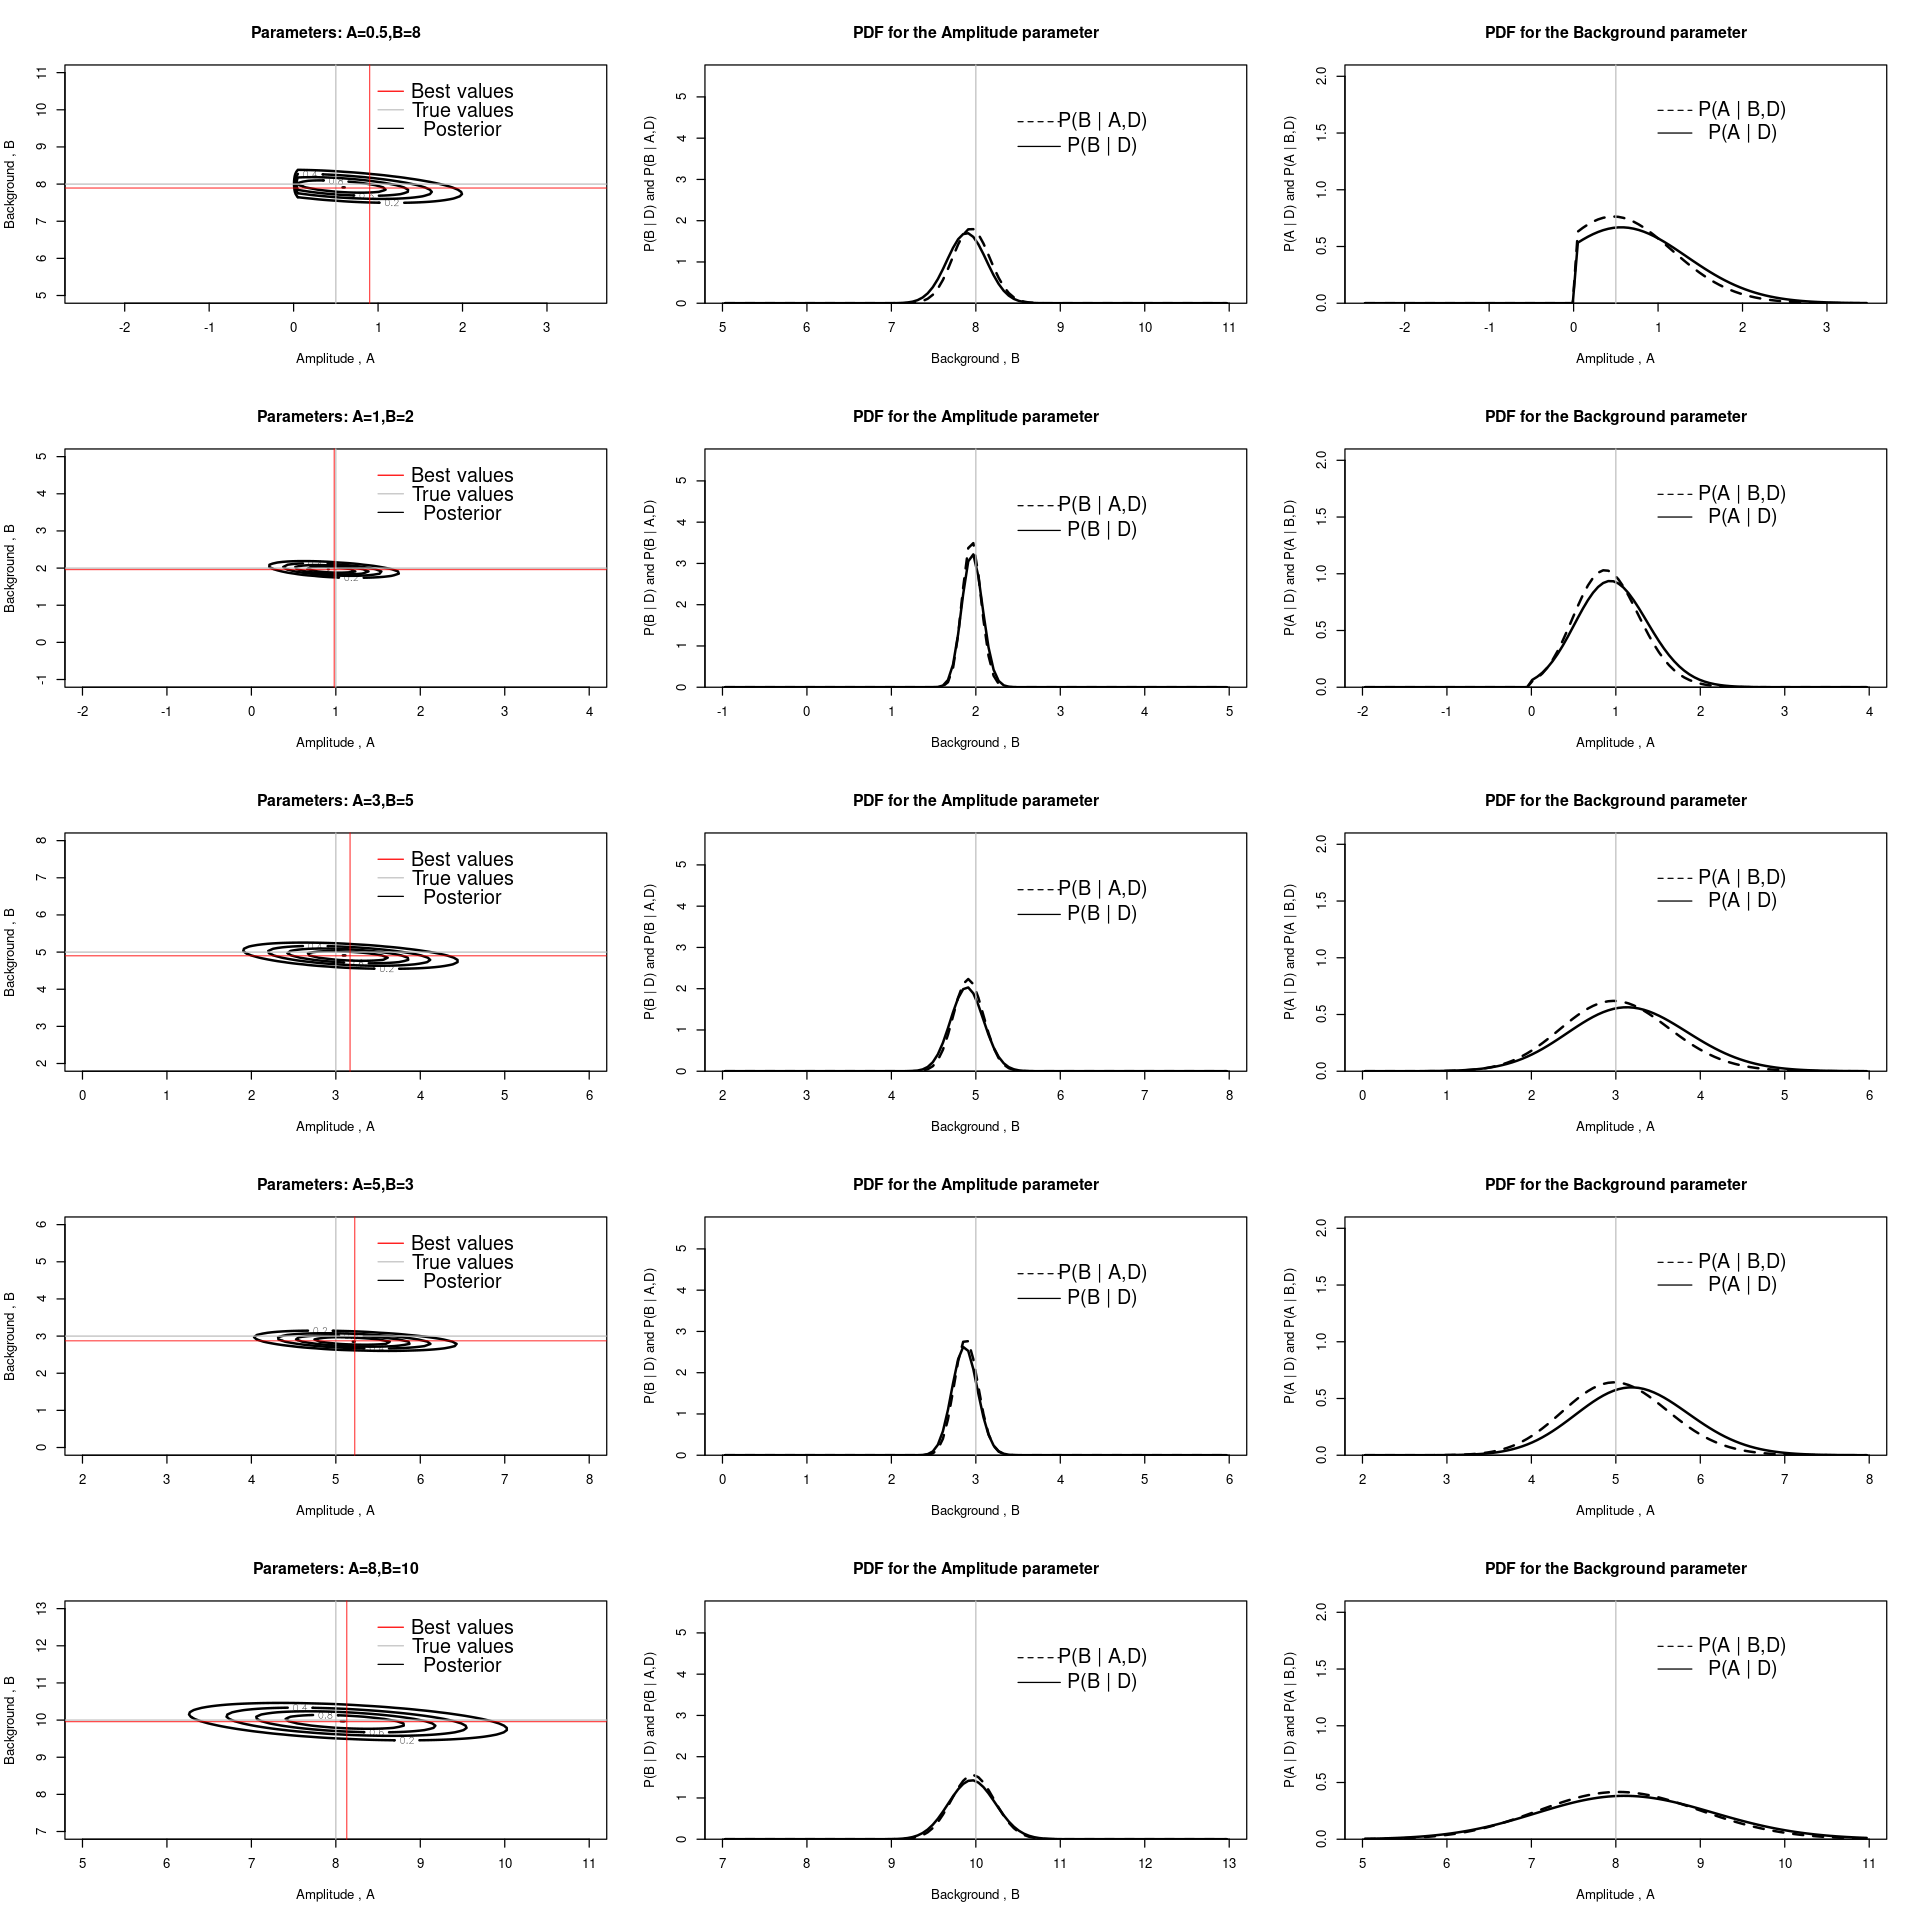

In [29]:
options(repr.plot.width = 15, repr.plot.height =13)
layout(matrix(1:15, nrow=5, ncol = 3, byrow = TRUE))

for (i in 1:5){
    c_plot(v[[i]][[1]],v[[i]][[2]],0,1,5,a_i[[i]],b_i[[i]],main = paste0("Parameters: A=",a_i[[i]],",B=",b_i[[i]]),alim = c(a_i[[i]]-3, a_i[[i]]+3),blim = c(b_i[[i]]-3, b_i[[i]]+3), delta_a, delta_b)
}

From the previous results is possible to understand how both the signal strenght and background are important for a successful inference. In fact a lower background baseline allows to recognize the signal even if it is very weak, as it can be seen for set A=1, B=2. However the signal as a in importance too, since it permits to distinguish the signal counts from the effective background. 